# Preprocess the TLC Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import math

In [2]:
spark = (
    SparkSession.builder.appName("preprocess")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "3g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

In [3]:
sdf_2019 = spark.read.parquet('../data/raw/yellow_taxi_data_2019/')

# Preliminary data analysis

In [4]:
print(f'total of {sdf_2019.count():,} rows')

total of 84,598,444 rows


In [5]:
sdf_2019.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [6]:
# Check the statistics for interested attributes
sdf_2019.describe(['tip_amount', 'trip_distance', 'passenger_count', 'fare_amount']).show()

+-------+------------------+------------------+------------------+------------------+
|summary|        tip_amount|     trip_distance|   passenger_count|       fare_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|          84598444|          84598444|          84154061|          84598444|
|   mean| 2.190078737505638|3.0183506184817515|1.5626654190817957|13.412639732835764|
| stddev|15.638996154306168| 8.093902044464816|1.2079081585219809|174.17668755385404|
|    min|            -221.0|         -37264.53|               0.0|           -1856.0|
|    max|         141492.02|          45977.22|               9.0|          943274.8|
+-------+------------------+------------------+------------------+------------------+



<AxesSubplot:ylabel='Count'>

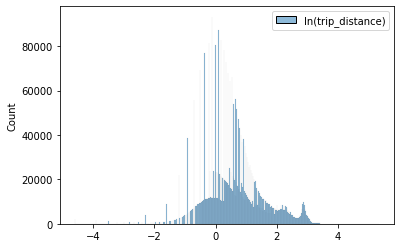

In [7]:
# It seems like trip_distance approximately follow a log-normal distribution
log_trip_distance = sdf_2019.filter(F.col('trip_distance') > 0).select(F.log(F.col('trip_distance')))
df = log_trip_distance.sample(0.05, seed=0).toPandas()
sns.histplot(data=df)

In [8]:
# we will treat data that is 3 std away from mean as outlier
stat = log_trip_distance.select(F.mean('ln(trip_distance)').alias('mean'), 
                                F.stddev('ln(trip_distance)').alias('std')).collect()

lower, upper = math.exp(stat[0]['mean'] - 3*stat[0]['std']), math.exp(stat[0]['mean'] + 3*stat[0]['std'])
lower, upper

(0.10780246363537173, 31.786485869296914)

In [9]:
# Check null value
for column in sdf_2019.columns:
    print(f'{column} has {sdf_2019.where(F.col(column).isNull()).count()} null value(s)')

VendorID has 0 null value(s)
tpep_pickup_datetime has 0 null value(s)
tpep_dropoff_datetime has 0 null value(s)
passenger_count has 444383 null value(s)
trip_distance has 0 null value(s)
RatecodeID has 444383 null value(s)
store_and_fwd_flag has 444383 null value(s)
PULocationID has 0 null value(s)
DOLocationID has 0 null value(s)
payment_type has 0 null value(s)
fare_amount has 0 null value(s)
extra has 0 null value(s)
mta_tax has 0 null value(s)
tip_amount has 0 null value(s)
tolls_amount has 0 null value(s)
improvement_surcharge has 0 null value(s)
total_amount has 0 null value(s)
congestion_surcharge has 5300601 null value(s)
airport_fee has 84598444 null value(s)


In [10]:
# Modify the sdf
# line 23~31: Drop the attributes that we are not interested in
# line 32: Drop the rows with null passenger_count and RatecodeID
# line 33~34: Remove data not in 2019
# line 35: A reasonable tip amount between 0 and 250 which is at most 50% of fare amount (normally 15% ~ 20%)
# line 36: A reasonable trip distance is between 0.1078 and 31.7865 miles
# line 37: A fare amount is between $2.5(initial charge) and $500
# line 38: RateCodeID should be one of the integer in the range of 1-6
# line 39: Only trips paid by credit card are of our interest
# line 40: Passenger count must not be zero
# line 41~42: Zone 264, 265 are unknown zone
# line 43~46: Extract the pick-up month, day and hour
# line 47: trip_distance in kilometres
# line 48~49: duaration of trips
# line 50: weekday and weekend 
# line 51: is the tips > 0

def transform(sdf, year):
    """
    return a modified sdf
    """
    sdf_mdf = sdf \
            .drop('VendorID', 
                  'store_and_fwd_flag', 
                  'extra',
                  'mta_tax',
                  'improvement_surcharge',
                  'tolls_amount', 
                  'total_amount',
                  'congestion_surcharge',
                  'airport_fee') \
            .dropna(how='any') \
            .filter((F.year('tpep_pickup_datetime') == year) & 
                    (F.year('tpep_dropoff_datetime') == year) == True) \
            .filter((F.col('tip_amount') >= 0) & (F.col('tip_amount') < 250)) \
            .filter((F.col('trip_distance') > lower) & (F.col('trip_distance') < upper)) \
            .filter((F.col('fare_amount') > 2.5) & (F.col('fare_amount') < 500)) \
            .filter(F.col('RatecodeID').isin(list(range(1, 7)))) \
            .filter(F.col('payment_type') == 1) \
            .filter(F.col('passenger_count') != 0) \
            .filter((F.col('PULocationID').isin([264, 265]) == False) & 
                    (F.col('DOLocationID').isin([264, 265]) == False)) \
            .withColumn('PUMonth', F.month(F.col('tpep_pickup_datetime'))) \
            .withColumn('PUDay', F.dayofmonth(F.col('tpep_pickup_datetime'))) \
            .withColumn('PUDayofweek', (F.dayofweek(F.col('tpep_pickup_datetime'))+5)%7+1) \
            .withColumn('PUHour', F.hour(F.col('tpep_pickup_datetime'))) \
            .withColumn('trip_distance(km)', F.col('trip_distance') * 1.60934) \
            .withColumn('time_difference(s)', F.col('tpep_dropoff_datetime').cast('long') - \
                                                F.col('tpep_pickup_datetime').cast('long')) \
            .withColumn('is_weekend', F.dayofweek('tpep_pickup_datetime').isin([1, 7])) \
            .withColumn('tips_given', F.col('tip_amount') > 0)
    return sdf_mdf


new_sdf_2019 = transform(sdf_2019, 2019)

In [11]:
aggregated_result1 = new_sdf_2019 \
                     .groupBy("PULocationID", 
                              "PUMonth", 
                              "PUDay"
                            ) \
                     .agg(
                       F.max("tip_amount").alias("max_tip_amount_usd"),
                       F.mean("tip_amount").alias("avg_tip_amount_usd"),
                       F.count("PULocationID").alias("total_trip_count")
                   )

aggregated_result1.show()

+------------+-------+-----+------------------+------------------+----------------+
|PULocationID|PUMonth|PUDay|max_tip_amount_usd|avg_tip_amount_usd|total_trip_count|
+------------+-------+-----+------------------+------------------+----------------+
|         249|      2|   28|             20.15|  2.65737012113055|            3715|
|         106|      3|    2|              4.45|1.8336363636363635|              22|
|         191|      3|    2|               0.0|               0.0|              13|
|         224|      3|    3|             12.21| 2.557177419354841|             372|
|          12|      3|    3|              6.45|3.4816666666666665|              30|
|         223|      3|    3|             15.26| 5.234727272727272|              55|
|          54|      3|    4|             13.76|             4.834|               5|
|         126|      3|    5|               0.0|               0.0|               4|
|         200|      3|    5|              10.0|               1.0|          

In [12]:
aggregated_result2 = new_sdf_2019 \
                     .groupBy("PULocationID",
                              "passenger_count",
                             ) \
                     .agg(
                       F.max("tip_amount").alias("max_tip_amount_usd"),
                       F.mean("tip_amount").alias("avg_tip_amount_usd"),
                       F.count("PULocationID").alias("total_trip_count")
                       ) \
                     .orderBy("passenger_count")
                     

aggregated_result2.show()

+------------+---------------+------------------+-------------------+----------------+
|PULocationID|passenger_count|max_tip_amount_usd| avg_tip_amount_usd|total_trip_count|
+------------+---------------+------------------+-------------------+----------------+
|          17|            1.0|              30.0| 1.2023368765331155|            6115|
|          27|            1.0|             15.59|  2.877407407407407|              27|
|          77|            1.0|              15.0|0.15983900928792572|            1615|
|         164|            1.0|             150.0| 2.7505833149564425|          984031|
|          53|            1.0|             16.44|              0.875|             498|
|         238|            1.0|             220.0| 2.4332175975945103|          874665|
|         146|            1.0|              75.0| 2.6106248608534313|           26950|
|         226|            1.0|             155.0| 4.0204349425964105|           40764|
|         147|            1.0|             

In [13]:
# write out the aggregated results
aggregated_result1.write.mode('overwrite').parquet('../data/curated/aggregated_result1_2019')
aggregated_result2.write.mode('overwrite').parquet('../data/curated/aggregated_result2_2019')

# Subsampling

In [14]:
# Sample data will be stratified by month
# Due to limited memory, 40% of the actual data will be use for modeling, 5% will be used for plotting
sampled_sdf_for_mod = new_sdf_2019.sampleBy("PUMonth", {i : 0.4 for i in range(1, 13)}, seed=0)
sampled_sdf_for_plot = new_sdf_2019.sampleBy("PUMonth", {i : 0.05 for i in range(1, 13)}, seed=0)

# Write the parquet
sampled_sdf_for_mod.write.mode('overwrite').parquet("../data/curated/sample_data_2019")
sampled_sdf_for_plot.write.mode('overwrite').parquet("../data/curated/sample_data_for_plotting_2019")

In [15]:
# Also the same procedure will be applied to 2020 data
sdf_2020 = spark.read.parquet('../data/raw/yellow_taxi_data_2020/')
new_sdf_2020 = transform(sdf_2020, 2020)

In [16]:
# Due to lockdown of NYC in March, 2020, the records has declined substantially
# I will use data from January to February to validate model predictions
reduced_sdf = new_sdf_2020.filter(F.col("PUMonth").isin([1, 2]))
reduced_sdf.write.mode('overwrite').parquet("../data/curated/sample_data_2020")